In [1]:
import numpy as np
#import scipy
import math
from scipy import integrate, LowLevelCallable
from scipy.integrate import odeint,solve_ivp
import matplotlib.pyplot as plt
import os, ctypes


In [2]:
# Kinetic correlations and parameters
# Billimoria 1981, Weng 1975 and Price 1977, the hydrogenation of Benzene example!!
prams = {'k0': 3.17e-2,                 # kmol/kgsPa
        'K0': 3.17e13,                 # 1/Pa
        'E' : 5.76e7,                   # J/kmol
        'Q': 6.89e7,                    # J/kmol (-) sign
        'kd0': 1.80e-4,                 # 1/Pa/s
        'Ed': 4.53e6,                   # J/kmol
        'R': 8.3145,                    # J/mol/K
        'MT': 4.05e-4,                  # kg/kmol (from Weng, 1.03e-3, mol/kg_catalyst)
        'DeB': 4.5e-5,                  # m2/s
        'rho_Cp': 1.46e-6,              # J/m3/oC
        'eps': 0.58,
        'rho_B': 4.14e-2,               # kg/m3
        'dH': 2.09e8,                   # J/kmol
        'alpha': 0.32,                  # J/m2K
        'Le':1.48
        }                 


In [3]:
# ccalculation of <rho*Cp>
# <rho*Cp> = rho*Cp (catalyst + diluent) + rho*Cp (reactor wall + thermo_well) + rho_g*eps*Cp_g
# rho*Cp (catalyst + diluent) = [W_T*Cp_c + (1-W_T)*Cp_d]*rho_B

In [4]:
def lambda_e(LeH,rho_g,Cp_g,U,dp):
    return 5.1*LeH+0.8*rho_g*Cp_g*U*dp

In [5]:
def cp_g(xB,xH):
    return (96.86*xB + 2.902*xH)*10**4

In [6]:
def mw_g(xB,xH):
    return 78.12*xB + 2.106*xH

In [7]:
def rho_g_m1(cB,xB,xH):
    return cB*MW_g(xB,xH)/xB

In [8]:
def rho_g_m2(MW_g,P,T0):
    return MW_g*273.16*P/(22.161 + 1.0132e5*T0)

In [9]:
def cp_H(T):
    return 2.9199e4 + 2.0515*(T-400)-1.256e-2*(T-499)**2

In [10]:
def cp_B(T):
    return 1.1196e5 + 2.7528e2*(T-400)-2.1562e-1*(T-400)**2

In [11]:
dT_ad = lambda xB0,dH,MW_g,Cp_g: xB0*(-dH)/(MW_g*Cp_g)
#dT_ad(0.5,120,65,4.14)


In [12]:
# Catalyst effectiveness parameters
pramc = {'Blh': 1,           # no units
         'Blm': 6.5,         # no units, assuming j_d = j_h
         'h': 2.2e2,         # J/m2/s/oC
         'km': 4.1e-2,       # m/s
         'rB': 0.162,        # kmol/m3/s (= k1*cB), assuming kinetics of first order
         'kl': 7.6e-2,       # m3/kg/s
         'rho_c': 4.3e3,     # kg/m3
         'Dc': 5.2e-6,       # m2/s
         'Lc': 0.15,         # J/m/s/oC
         'phi': 2.2,         # no units, r_p/(kl*rho_c/Dc)^(1/3),(2.2 for 12 mesh and 1.1 for 20 mesh)
         'gma': 3.3,         # no units, E/RT = 2700/(1.98*413)
         'bta': 8.56e-3      # no units, cB_0*(-dH)*Dc/(Lc*T_B) 
        }

In [13]:
def rB(P,xB,xH,a,T,prams):
    k0 = prams['k0']                 
    K0 = prams['K0']                 
    E =  prams['E']                 
    Q =  prams['Q']
    R =  prams['R']
    r = (k0*K0*np.exp((Q-E)/(R*T))*P**2*xB*xH)/(1 + K0*np.exp(Q/(R*T))*P*xB)*a
    return r

def rT(P,xT,a,T,prams):
    kd0 = prams['k0']   
    Ed =  prams['Ed']                 
    R =  prams['R']
    MT = prams['MT']
    r = (kd0*np.exp((-Ed)/(R*T))*P*xT*a)*MT
    return r

In [14]:
# Initial conditions

In [15]:
x0 = {'x_B':0.0212,'x_T':0.000212,'F0':1000, 'a':1, 'T0':70, 'cT0':72} # for partially deactivated (cT0 = 167 ppm)

In [16]:
params = {'D':0.01,'U':0.005,'k':0.055,'Le':1.48,'DeltaH':2.062e8}

In [17]:
def R(c,k):
    r = k*c
    return r

In [18]:
def H(DeltaH,r):
    Q = DeltaH*r
    return Q

In [19]:
def mass_energy_bal(y, t,D,U,Le):
    # Define concentrations and Temps according to the output y
    c = y[::5]    # Benzene concentration
    h = y[1::5]
    s = y[2::5]   # sulfur concentration
    a = y[3::5]   # catalyst activity
    T = y[4::5]   # Temperature
    
    dx = 0.025
    P = 1.01e5 
    
    prams = {'k0': 3.17e-2,                  # kmol/kgsPa
             'K0': 3.17e13,                 # 1/Pa
             'E' : 5.76e7,                   # J/kmol
             'Q': 6.89e7,                    # J/kmol (-) sign
             'kd0': 1.80e-4,                 # 1/Pa/s
             'Ed': 4.53e6,                   # J/kmol
             'R': 8.3145,                    # J/mol/K
             'MT': 4.05e-4,                  # kg/kmol (from Weng, 1.03e-3, mol/kg_catalyst)
             'DeB': 4.5e-5,                  # m2/s
             'rho_Cp': 1.46e-6,              # J/m3/oC
             'eps': 0.58,
             'rho_B': 4.14e-2,               # kg/m3
             'dH': 2.09e8,                   # J/kmol
             'alpha': 0.32,                  # J/m2K
             'Le':1.48                       # W/mK             
              }
    rho_B  = prams['rho_B']
    eps    = prams['eps']
    rho_Cp = prams['rho_Cp']
    dH     = prams['dH']
   
    # initialize the output derivatives
    dydt = np.empty_like(y)

    # from the interleaved output derivatives slice out dcdt and dTdt
    # vectors in dydt.
    dcdt = dydt[::5]
    dhdt = dydt[1::5]
    dsdt = dydt[2::5]
    dadt = dydt[3::5]
    dTdt = dydt[4::5]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))+ U*0
    
    dcdt[1:-1] = D * (c[:-2]-2.0*c[1:-1] + c[2:]) / dx**2 + U *(c[2:] - c[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))
        
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/dx + \
                     (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))
    

    dhdt[0]    = D * (-2.0*h[0] + 2.0*h[1]) / dx**2 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))+ U*0
    
    dhdt[1:-1] = D * (h[:-2]-2.0*h[1:-1] + h[2:]) / dx**2 + U *(h[2:] - h[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))
    
    dhdt[-1]   = D * (- 2.0*h[-1] + 2.0*h[-2]) / dx**2 + U *(h[-1]-h[-2])/dx + \
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1])) #*rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    
    
                  
    dsdt[0]    = D * (-2.0*s[0] + 2.0*s[1]) / dx**2 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                  rT(P,s[0],a[0],T[0],prams) + U*0
                  
    dsdt[1:-1] = D * (s[:-2]-2.0*c[1:-1] + s[2:]) / dx**2 + U *(s[2:] - s[:-2])/(2*dx) + \
                 (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* rT(P,s[1:-1],a[1:-1],T[1:-1],prams)
        
    dsdt[-1]   = D * (- 2.0*s[-1] + 2.0*s[-2]) / dx**2 + U *(s[-1]-s[-2])/dx +\
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))* rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dadt[0]    = rT(P,s[0],a[0],T[0],prams) 
    dadt[1:-1] = rT(P,s[1:-1],a[1:-1],T[1:-1],prams) 
    dadt[-1]   = rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dTdt[0]    = Le/rho_Cp * (-2.0*T[0] + 2.0*T[1]) / dx**2 + (U*cp_g(c[0],h[0])*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))*0 + \
                  (eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))
                  
    dTdt[1:-1] = Le/rho_Cp * (T[:-2]-2.0*T[1:-1] + T[2:]) / dx**2 + U*cp_g(c[1:-1],h[1:-1])*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1])/(rho_Cp*mw_g(c[1:-1],h[1:-1]))*(T[2:] - T[:-2])/(2*dx) + \
                  (eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))/(rho_Cp*mw_g(c[1:-1],h[1:-1]))
                  
    dTdt[-1]   = Le/rho_Cp * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + (U * cp_g(c[-1],h[-1])* rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1])/(rho_Cp*mw_g(c[-1],h[-1]))) * (T[-1]-T[-2])/dx + \
                 (eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))/(rho_Cp*mw_g(c[-1],h[-1]))
    
    return dydt


In [20]:
x_0 = [x0['x_B'],1-x0['x_B']-x0['x_T'],x0['x_T'],x0['a'],x0['T0']+273.15]

In [21]:
y_0 = x_0 + x_0

In [22]:
y0 = np.array(y_0)

In [23]:
t = np.linspace(0, 50, 101)
D = params['D']
U = params['U']
k = params['k']
Le = params['Le']
DeltaH = params['DeltaH']


In [24]:
n = t.size
#print(n)
#t[0:n-1],t[0:-1]

In [25]:
c = y0[::5]
c

array([0.0212, 0.0212])

In [26]:
h = y0[1::5]
h

array([0.978588, 0.978588])

In [27]:
a = y0[2::5]
a

array([0.000212, 0.000212])

In [28]:
T = y0[3::5]
T

array([1., 1.])

In [29]:
# The cell below is for zeros and NaN divide

In [30]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'invalid': 'warn', 'over': 'warn', 'under': 'ignore'}

In [31]:
solb = odeint(mass_energy_bal, y0, t, args= (D, U,Le), ml=2, mu=2)
solb.shape

(101, 10)

In [32]:
# Testing calculation of terms

In [33]:
c = y0[::5]    
h = y0[1::5]
s = y0[2::5]  
a = y0[3::5]
T = y0[4::5]   

In [34]:
rho = 0.58*rho_g_m2(mw_g(c[0],h[0]),1.103e5,T[0])

In [35]:
rho

1.8682697855678063

In [36]:
rT(1.103e5,s[0],a[0],T[0],prams)

0.0

In [37]:
#rB(1.103e5,c[0],h[0],a[0],T[0],prams)

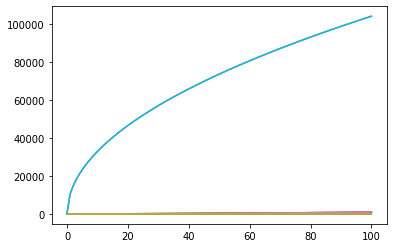

In [38]:
plt.figure()
plt.plot(solb)
plt.show()

In [39]:
t_span = np.array([0,50])
times = np.linspace(t_span[0], t_span[1], 101)

In [40]:
def mass_energy_bal2(t,y):
    # Define concentrations and Temps according to the output y
    c = y[::5]    # Benzene concentration
    h = y[1::5]
    s = y[2::5]   # sulfur concentration
    a = y[3::5]   # catalyst activity
    T = y[4::5]   # Temperature
    
    dx = 0.025
    P = 1.103e5 
    U  = 0.01
    
    prams = {'k0': 3.17e-2,                  # kmol/kgsPa
             'K0': 3.17e-13,                 # 1/Pa
             'E' : 5.76e7,                   # J/kmol
             'Q': 6.89e7,                    # J/kmol (-) sign
             'kd0': 1.80e-4,                 # 1/Pa/s
             'Ed': 4.53e6,                   # J/kmol
             'R': 8.3145,                    # J/mol/K
             'MT': 4.05e-4,                  # kg/kmol (from Weng, 1.03e-3, mol/kg_catalyst)
             'DeB': 4.5e-5,                  # m2/s
             'rho_Cp': 1.46e-6,              # J/m3/oC
             'eps': 0.58,
             'rho_B': 4.14e-2,               # kg/m3
             'dH': 2.09e8,                   # J/kmol
             'alpha': 0.32,                  # J/m2K
             'Le':1.48                       # W/mK             
              } 
    
    rho_B  = prams['rho_B']
    eps    = prams['eps']
    rho_Cp = prams['rho_Cp']
    dH     = prams['dH']   
    D  =  prams['DeB']
    Le =  prams['Le']
        
    
    # initialize the output derivatives
    dydt = np.empty_like(y)

    # from the interleaved output derivatives slice out dcdt and dTdt
    # vectors in dydt.
    dcdt = dydt[::5]
    dhdt = dydt[1::5]
    dsdt = dydt[2::5]
    dadt = dydt[3::5]
    dTdt = dydt[4::5]

    # Compute dc/dt and dT/dt considering the boundaries (end points) and the interior points
    
    dcdt[0]    = D * (-2.0*c[0] + 2.0*c[1]) / dx**2 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))+ U*0
    
    dcdt[1:-1] = D * (c[:-2]-2.0*c[1:-1] + c[2:]) / dx**2 + U *(c[2:] - c[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))
        
    dcdt[-1]   = D * (- 2.0*c[-1] + 2.0*c[-2]) / dx**2 + U *(c[-1]-c[-2])/dx + \
                     (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))
    

    dhdt[0]    = D * (-2.0*h[0] + 2.0*h[1]) / dx**2 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))+ U*0
    
    dhdt[1:-1] = D * (h[:-2]-2.0*h[1:-1] + h[2:]) / dx**2 + U *(h[2:] - h[:-2])/(2*dx) + \
                     (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))
    
    dhdt[-1]   = D * (- 2.0*h[-1] + 2.0*h[-2]) / dx**2 + U *(h[-1]-h[-2])/dx + \
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1])) #*rB(P,c[-1],h[-1],a[-1],T[-1],prams)
    
    
                  
    dsdt[0]    = D * (-2.0*s[0] + 2.0*s[1]) / dx**2 + (mw_g(c[0],h[0])*rho_B)/(eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))* \
                  rT(P,s[0],a[0],T[0],prams) + U*0
                  
    dsdt[1:-1] = D * (s[:-2]-2.0*c[1:-1] + s[2:]) / dx**2 + U *(s[2:] - s[:-2])/(2*dx) + \
                 (mw_g(c[1:-1],h[1:-1])*rho_B)/(eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))* rT(P,s[1:-1],a[1:-1],T[1:-1],prams)
        
    dsdt[-1]   = D * (- 2.0*s[-1] + 2.0*s[-2]) / dx**2 + U *(s[-1]-s[-2])/dx +\
                 (mw_g(c[-1],h[-1])*rho_B)/(eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))* rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dadt[0]    = rT(P,s[0],a[0],T[0],prams) 
    dadt[1:-1] = rT(P,s[1:-1],a[1:-1],T[1:-1],prams) 
    dadt[-1]   = rT(P,s[-1],a[-1],T[-1],prams)
    
    
    dTdt[0]    = Le/rho_Cp * (-2.0*T[0] + 2.0*T[1]) / dx**2 + (U*cp_g(c[0],h[0])*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))*0 + \
                  (eps*rho_g_m2(mw_g(c[0],h[0]),P,T[0]))/(rho_Cp*mw_g(c[0],h[0]))
                  
    dTdt[1:-1] = Le/rho_Cp * (T[:-2]-2.0*T[1:-1] + T[2:]) / dx**2 + U*cp_g(c[1:-1],h[1:-1])*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1])/(rho_Cp*mw_g(c[1:-1],h[1:-1]))*(T[2:] - T[:-2])/(2*dx) + \
                  (eps*rho_g_m2(mw_g(c[1:-1],h[1:-1]),P,T[1:-1]))/(rho_Cp*mw_g(c[1:-1],h[1:-1]))
                  
    dTdt[-1]   = Le/rho_Cp * (-2.0*T[-1] + 2.0*T[-2]) / dx**2 + (U * cp_g(c[-1],h[-1])* rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1])/(rho_Cp*mw_g(c[-1],h[-1]))) * (T[-1]-T[-2])/dx + \
                 (eps*rho_g_m2(mw_g(c[-1],h[-1]),P,T[-1]))/(rho_Cp*mw_g(c[-1],h[-1]))
    return dydt


In [41]:
solc = solve_ivp(mass_energy_bal2,t_span,y0, method='RK45', t_eval= times, dense_output=True,vectorized=True)

In [42]:
# solc

In [43]:
solc.y[0].shape

(101,)

In [44]:
x_solc1 = solc.sol(t).T

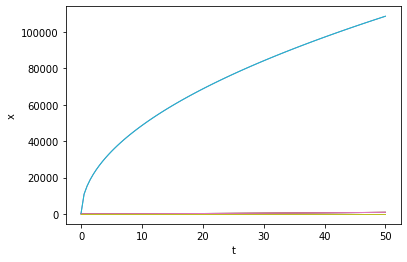

In [45]:
plt.figure()
plt.plot(t, x_solc1, linewidth=1)
plt.xlabel('t')
plt.ylabel('x')
plt.show()

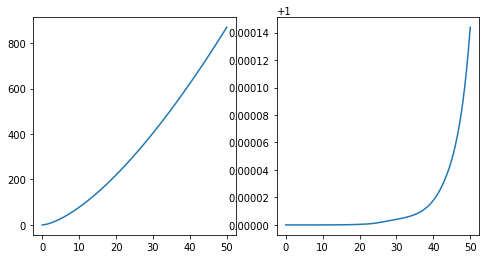

In [46]:
fig, axs = plt.subplots(1,2,figsize = (8,4))
axs[0].plot(solc.t, solc.y[0])
axs[1].plot(solc.t, solc.y[3])
plt.show()

In [47]:
# Example 
#v(n) = u(n+1)-u(n-1)/2*dt
#u'(0), v(0) = 0
#n(n) = u(n)-u(n-1)/dt
T = 100
dt = 0.025
Nt = int(round(T/dt))
u = np.zeros(Nt+1)
t = np.linspace(0, Nt*dt, Nt+1)

In [48]:
v = np.zeros_like(u) # or v = np.zeros(len(u))
# Use central difference for internal points
for i in range(1, len(u)-1):
    v[i] = (u[i+1] - u[i-1])/(2*dt)
# Use initial condition for u’(0) when i=0
v[0] = 0
# Use backward difference at the final mesh point
v[-1] = (u[-1] - u[-2])/dt

In [49]:
v = np.zeros_like(u)
v[1:-1] = (u[2:] - u[:-2])/(2*dt) # central difference
v[0] = 0 # boundary condition u’(0)
v[-1] = (u[-1] - u[-2])/dt # backward difference

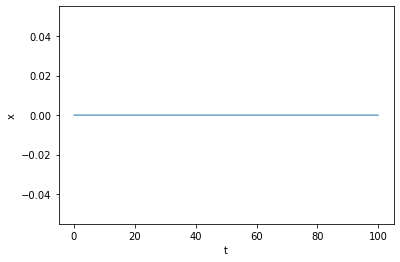

In [50]:
plt.figure()
plt.plot(t, v, linewidth=1)
plt.xlabel('t')
plt.ylabel('x')
plt.show()